In [1]:
#import functions
from curvature_functions import *
from wd_functions import *


In [2]:
#map_index_dest= sys.argv[1] #"map_index_0.csv"
#task_id= int(sys.argv[2]) #0

##reading the map_index csv
#print('reading the map_index csv')
#map_index=pd.read_csv(map_index_dest)
#input_var=list(map_index.columns) #variables for which values are being imported
#for i in range(len(input_var)):
#    if input_var[i] == 'folder_name':
#        dirname = map_index.loc[task_id,str(input_var[i])]
#    if input_var[i] == 'thickness':
#        thickness = map_index.loc[task_id,str(input_var[i])]
#        #init_mesh_path = 'gmsh_r_30_rotated_spherical_cap_theta_23.08_thickness_' + str(thickness) + '.pickle'
#    #var_dict[input_var[i]]=map_index.loc[task_id,str(input_var[i])]
#init_mesh_path = dirname + "runfiles/init_mesh.pickle"

dirname = ''
init_mesh_path = dirname + "runfiles/init_mesh.pickle"
thickness = 0.05

In [3]:
stages_df = pd.read_pickle(dirname+'runfiles/fit_lambdas_df.pkl')
stages = np.append(np.array(stages_df.iloc[0]["stage_init"]), np.array(stages_df.iloc[0:(len(np.unique(stages_df["stage_final"])))]["stage_final"]))
stage_names = np.array(stages_df.iloc[0:(len(np.unique(stages_df["stage_name"])))]["stage_name"])

scale = 77.66
crosssections = ['Across_DV', 'Along_DV']
ncols = len(stages) #number of stages, read stages_df.pkl and get unique of stage

#fig, axs = plt.subplots(3, ncols, figsize=(11*ncols, 24))
#titles = [str(x) for x in crosssections]
#projection_y = 'z'



In [ ]:
#take one file
#for each cross-section:
#    #--take the cross-section
#    #--find the center point - different for Across and Along DV
#    #--interpolate
#    #--get curvature
#    #--save
#    #--plot

#              #--scale and align - we leave this for now

In [127]:

#take one file
balls_timepoint = pd.read_csv(dirname + "sim_output/init_balls.csv")
springs_timepoint = pd.read_csv(dirname + "sim_output/init_springs.csv")

timepoint_pos = pd.read_csv(dirname + "sim_output/wL3 to 4hAPF.csv")
balls_timepoint[['x', 'y', 'z']] =  timepoint_pos[['x', 'y', 'z']]
springs_timepoint = update_springs(springs_timepoint, balls_timepoint[['x', 'y', 'z']])

crosssections = ['Across_DV', 'Along_DV']

Text(0.5, 1.0, 'Curvature')

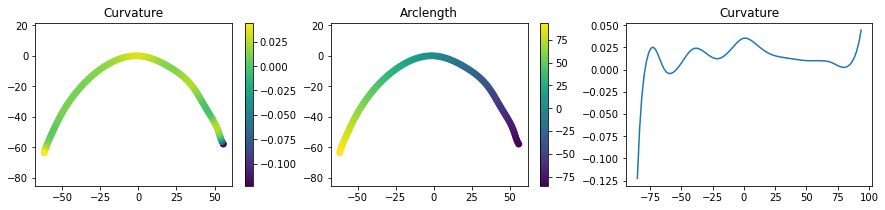

In [128]:
crosssection = crosssections[1]
#take the cross-section
projection_y = 'z'
projection_x = 'x' if crosssection == 'Across_DV' else 'y'
curve = get_2D_curve_from_simulation(balls_timepoint, springs_timepoint, projection_x = projection_x, projection_y = projection_y)

#interpolate - take curvature - define a center
curve = curve.rename(columns={projection_x:"x", projection_y:"y"})
smooth_curve = compute_2D_curve_curvature(curve)

#scale the curve
for prop in ["x", "y", "arclength"]: smooth_curve[prop+"_scaled"] = scale*smooth_curve[prop]
smooth_curve["curvature_scaled"] = smooth_curve["curvature"]/scale

#translate the curve
center_point = smooth_curve[smooth_curve["arclength_scaled"].abs() == smooth_curve["arclength_scaled"].abs().min()][["x_scaled","y_scaled"]].values[0]
smooth_curve[["x_scaled","y_scaled"]] = smooth_curve[["x_scaled", "y_scaled"]] - center_point

#save
smooth_curve.to_csv(dirname + 'sim_output/' + stage + '_' + crosssection + '_curve.csv', index = False)

#-------

#plot
fig,ax = plt.subplots(1,3, figsize = (15,3))
pos = ax[0].scatter(smooth_curve["x_scaled"], smooth_curve["y_scaled"], c = smooth_curve["curvature_scaled"])
ax[0].axis("equal")
fig.colorbar(pos, ax=ax[0])
ax[0].set_title("Curvature")

pos = ax[1].scatter(smooth_curve["x_scaled"], smooth_curve["y_scaled"], c = smooth_curve["arclength_scaled"])
ax[1].axis("equal")
fig.colorbar(pos, ax=ax[1])
ax[1].set_title("Arclength")

pos = ax[2].plot(smooth_curve["arclength_scaled"], smooth_curve["curvature_scaled"])
ax[2].set_title("Curvature")

In [56]:
def get_2D_curve_from_simulation(balls, springs, projection_x = 'x', projection_y = 'z',):
    
    #defining x and y values
    y = 'y' if projection_x == 'x' else 'x'
    [x, x1, x2, y, y1, y2, z, z1, z2 ] = [projection_x, projection_x + str(1), projection_x + str(2), #either x or y
                                      y, y + str(1), y + str(2), #either x or y
                                      projection_y, projection_y + str(1), projection_y + str(2)] #this is probably always z
    
    #get the top surface
    top_springs = springs[(springs['ball1'] >= len(balls)/2) & (springs['ball2'] >= len(balls)/2)]
    top_balls = balls[balls['ID'] >= len(balls)/2]
    
    #get springs that cross the xz plane
    #such springs will have the y values of their end points of different signs
    xz_plane_springs = top_springs[top_springs[y1]*top_springs[y2]<0]
    indices = xz_plane_springs.index
    
    #computing the point of intersection of the springs with the xz plane
    xz_plane_springs[x] = xz_plane_springs[x1] - xz_plane_springs[y1] * ((xz_plane_springs[x1] - xz_plane_springs[x2])/(xz_plane_springs[y1] - xz_plane_springs[y2]))
    xz_plane_springs[y] = 0
    xz_plane_springs[z] = xz_plane_springs[z1] - xz_plane_springs[y1] * ((xz_plane_springs[z1] - xz_plane_springs[z2])/(xz_plane_springs[y1] - xz_plane_springs[y2]))
    
    #making a df of just the intersection points
    xz_curve = xz_plane_springs[[x, z]] #.reset_index(drop=True)
    xz_curve['theta_xz'] = np.arctan(xz_curve[x]/xz_curve[z])
    xz_curve['norm_angle_xz'] = (xz_curve['theta_xz'] - min(xz_curve['theta_xz']))/(max(xz_curve['theta_xz']) - min(xz_curve['theta_xz']))
    for prop in ["DV_bool", "pathlength_scaled",]:
        if prop in top_balls.columns:
            #here we will take a mean of the prop between the two end points
            xz_curve[prop] = 0.5*(top_balls.loc[xz_plane_springs['ball1'].values, prop].values+top_balls.loc[xz_plane_springs['ball2'].values, prop].values)
    
    #sort the points by x
    xz_curve = xz_curve.sort_values(by = x, axis=0, ascending=False).reset_index(drop = True)
    
    return(xz_curve)

In [65]:
def compute_2D_curve_curvature(curve):
    
    #curve.columns = ['x', 'y']

    #curve = xz_curve.copy()

    for i in range(curve.index[1], curve.index[-1]):

        xi = curve.loc[i,'x']
        yi = curve.loc[i, 'y']
        xi0 = curve.loc[i-1,'x']
        yi0 = curve.loc[i-1, 'y']
        xi1 = curve.loc[i+1,'x']
        yi1 = curve.loc[i+1, 'y']

        #calculating. length. of curve
        if i == curve.index[1]:
            length = np.sqrt( (xi - xi0)**2 + (yi - yi0)**2 )
            curve.loc[i-1, 'arclength'] = 0

        length = length + np.sqrt( (xi1 - xi)**2 + (yi1- yi)**2 )
        curve.loc[i, 'arclength'] = curve.loc[i-1, 'arclength'] + np.sqrt( (xi - xi0)**2 + (yi - yi0)**2 )

        if i == curve.index[-2]:
            curve.loc[i + 1, 'arclength'] = curve.loc[i, 'arclength'] + np.sqrt( (xi1 - xi)**2 + (yi1 - yi)**2 )

    #setting arclength zero
    if "pathlength_scaled" in curve.columns:
        #choose the points with the minimum pathlength_scaled
        #take the average arclength of these points
        arclength_DV = curve[curve["pathlength_scaled"] == curve["pathlength_scaled"].min()]["arclength"].mean()
    else:
        #now we just take the mid point along the curve
        arclength_DV =  curve.loc[len(curve)-1, 'arclength']/2 #(curve_ventral.iloc[-1]['arclength'] + curve_dorsal.iloc[0]['arclength'])/2
    curve['arclength_offset'] = curve['arclength'] - arclength_DV

    #smooth cubic spline
    #s = 10
    degree = 5
    #bspline_x = Bspline(curve['arclength_offset'], curve['x'], k = degree)
    #bspline_y = Bspline(curve['arclength_offset'], curve['y'], k = degree)



    #t_x = [np.array(curve['arclength_offset'])[0]]*(int((len(curve) + degree + 1)/2)) + [np.array(curve['arclength_offset'])[-1]]*(int((len(curve) + degree + 1)/2))
    #t_y = t_x
    #break

    # t -> knots 
    # the function splrep will add k+1 knots as the initial point and k+1 knots as the last point
    # the size of t has to be n + k + 1 where n is the number of points
    # we have to add n + k + 1 - 2(k + 1)  = n - k - 1 knots ourselves
    # we can do this by dropping the first (k + 1)/2 points and the last (k+1)/2 points

    #t = np.array(curve['arclength_offset'])[int((degree + 1)/2):-int((degree + 1)/2)]

    spl_x = splrep(curve['arclength_offset'], curve['x'], k = degree, w = [1]*len(curve),
                   #task = -1, # to find the least square solution to the B spline
                   t = [3*min(curve['arclength_offset'])/4, min(curve['arclength_offset'])/2,min(curve['arclength_offset'])/4,0,max(curve['arclength_offset'])/4,max(curve['arclength_offset'])/2,3*max(curve['arclength_offset'])/4,]
                   #t = t
                  )
    spl_y = splrep(curve['arclength_offset'], curve['y'], k = degree, w = [1]*len(curve),
                   #task = -1, # to find the least square solution to the B spline
                   t = [3*min(curve['arclength_offset'])/4, min(curve['arclength_offset'])/2,min(curve['arclength_offset'])/4,0,max(curve['arclength_offset'])/4,max(curve['arclength_offset'])/2,3*max(curve['arclength_offset'])/4,]
                   #t = t
                  )

    arclengths = np.linspace(min(curve['arclength_offset']), max(curve['arclength_offset']), 100)

    #arclengths = np.linspace(max_negative_s, min_positive_s, 100)

    x = splev(arclengths, spl_x)
    y = splev(arclengths, spl_y)

    x_1 = splev(arclengths, spl_x, der = 1)
    x_2 = splev(arclengths, spl_x, der = 2)
    y_1 = splev(arclengths, spl_y, der = 1)
    y_2 = splev(arclengths, spl_y, der = 2)
    curvatures = (y_2*x_1 - x_2*y_1)/(x_1**2 + y_1**2)**(3/2)


    df = pd.DataFrame({
        #'disc':[disc_name]*len(arclengths),
        'arclength':arclengths,
        'x':x,
        'y':y,
        'curvature':curvatures
                      })

    #df_all = pd.concat([df_all,df], ignore_index = True)
    #df['curvatures_100'] = df.curvatures.rolling(100).mean()

    #np.allclose(spl(x), y)


    return(df)


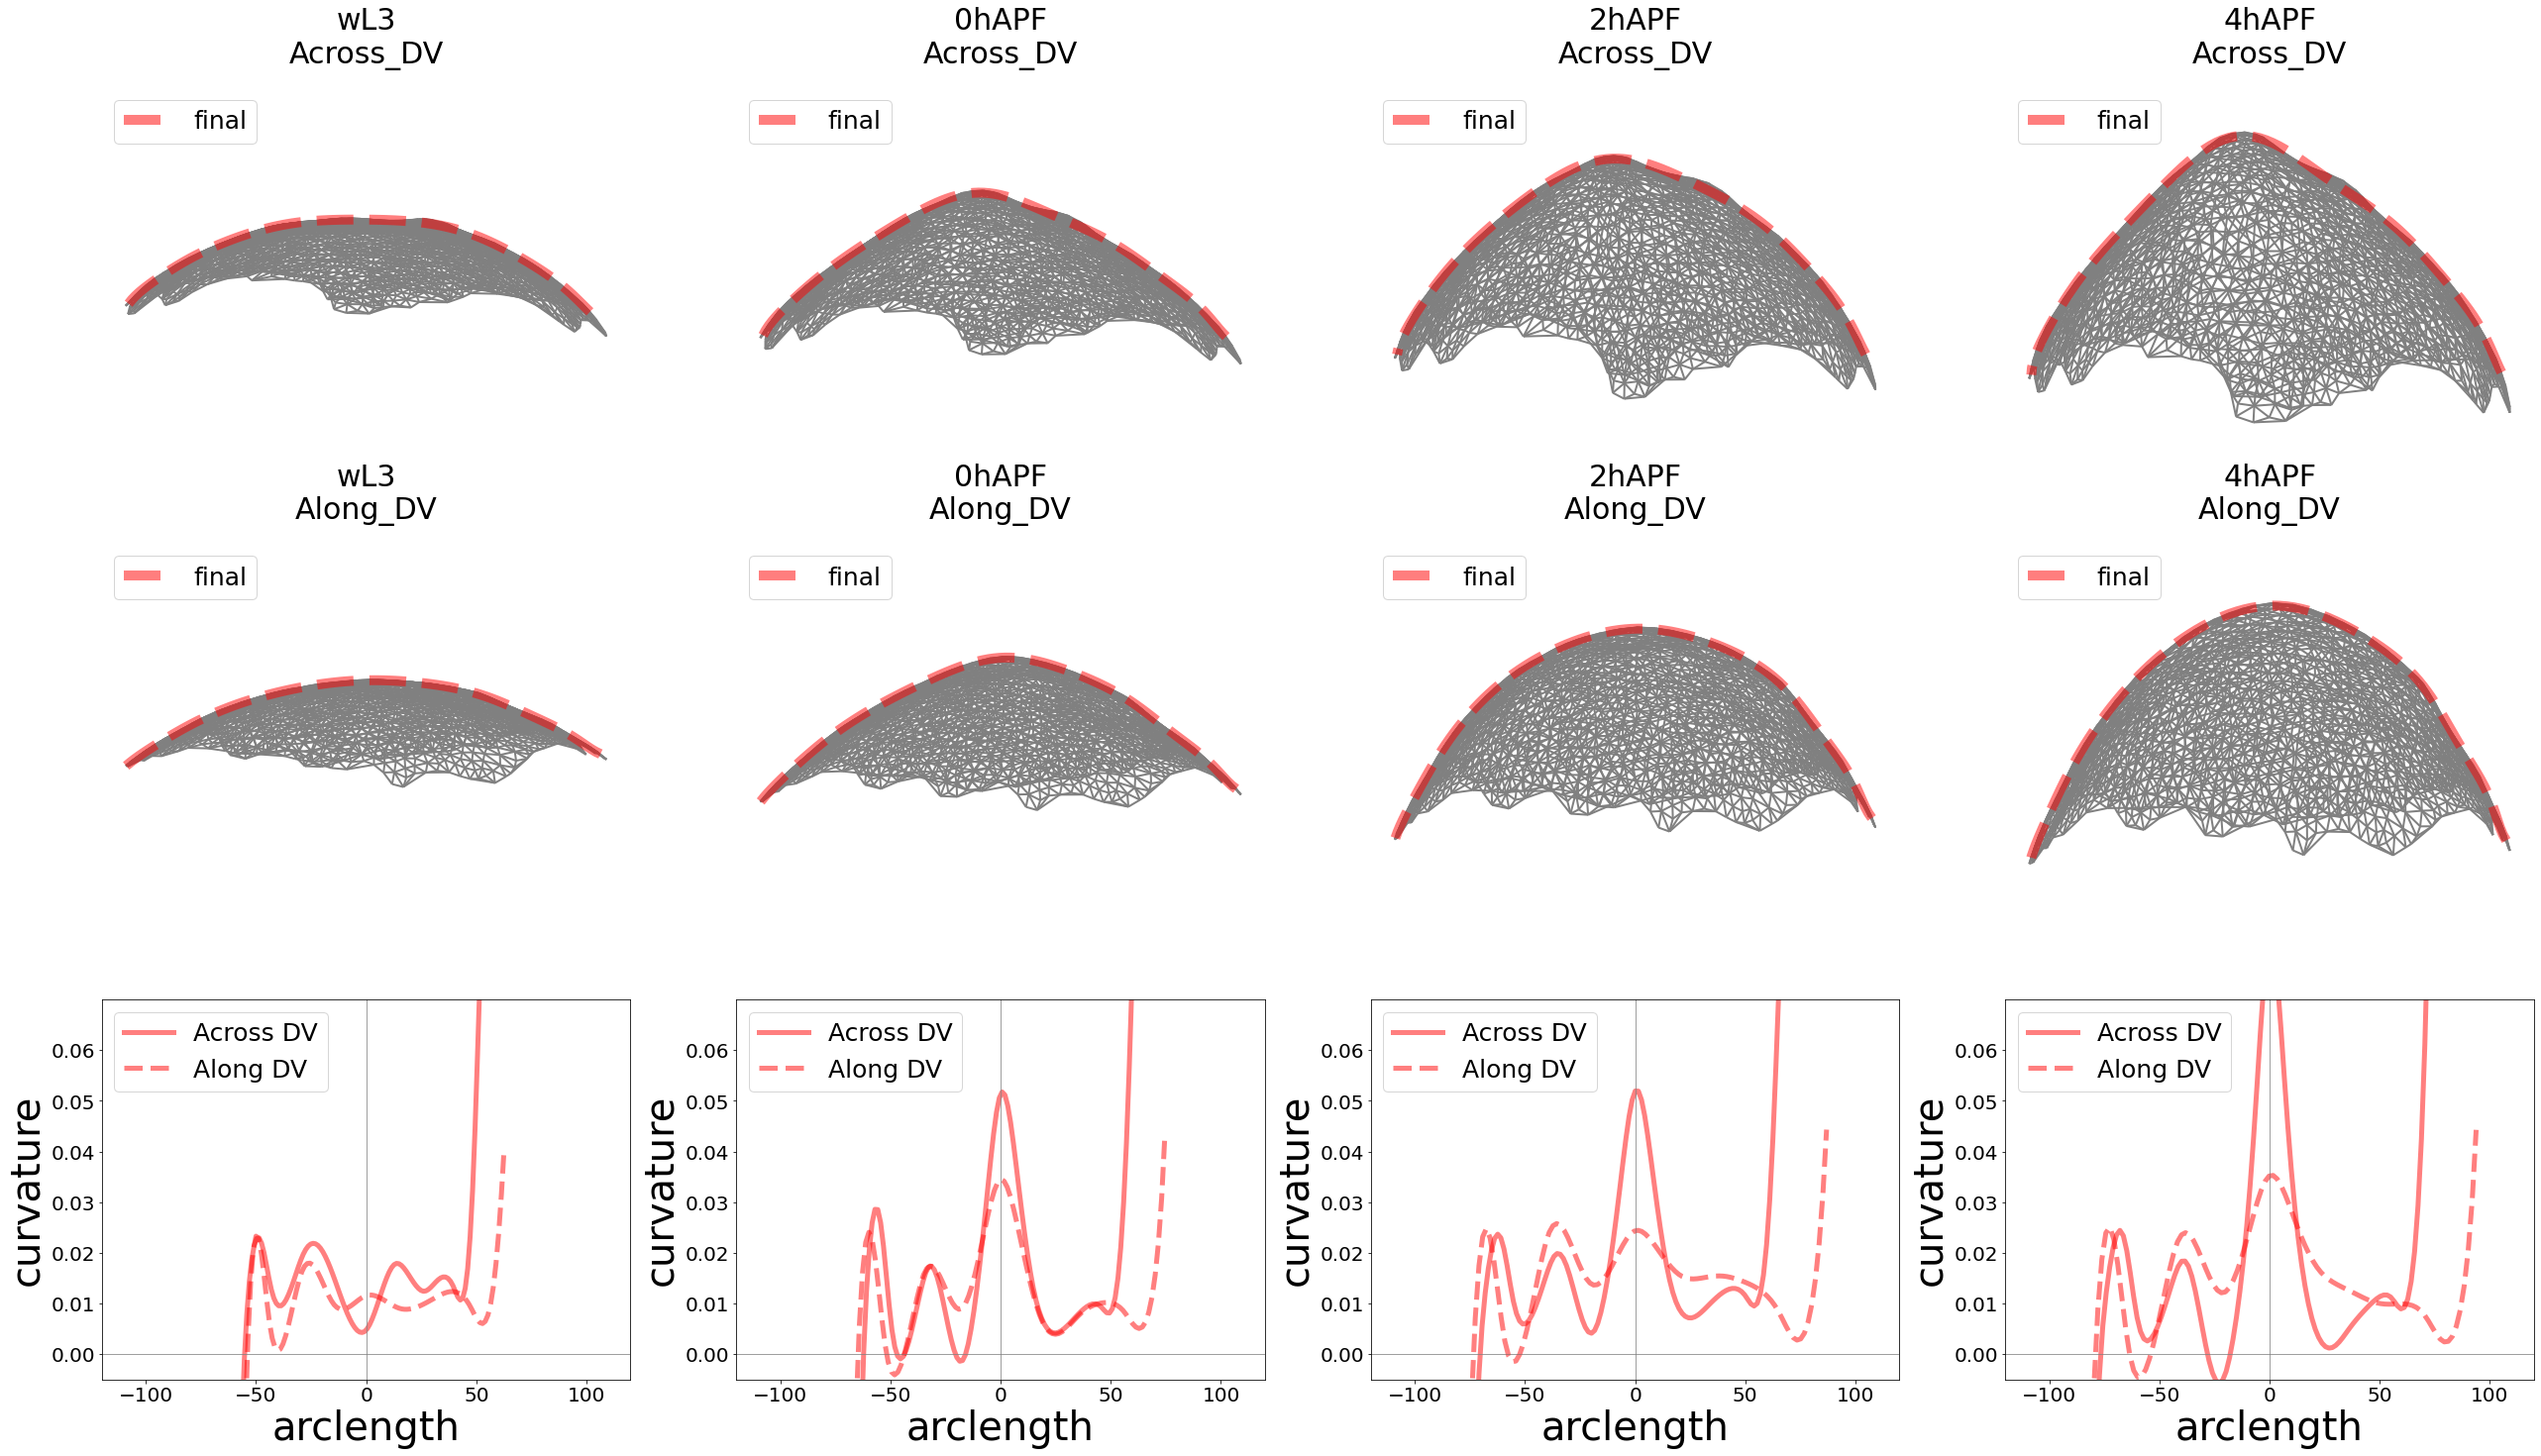

In [131]:
%matplotlib inline

init_mesh_path = dirname + "runfiles/init_mesh.pickle"

stages_df = pd.read_pickle(dirname+'runfiles/fit_lambdas_df.pkl')
stages = np.append(np.array(stages_df.iloc[0]["stage_init"]), np.array(stages_df.iloc[0:(len(np.unique(stages_df["stage_final"])))]["stage_final"]))
stage_names = np.array(stages_df.iloc[0:(len(np.unique(stages_df["stage_name"])))]["stage_name"])

scale = 77.66
crosssections = ['Across_DV', 'Along_DV']
ncols = len(stages) #number of stages, read stages_df.pkl and get unique of stage
projection_y = 'z'

#taking crosssections and measuring curvature

#take one which has all info (except xyz) which stay same between stages and crosssections
balls_timepoint = pd.read_csv(dirname + "sim_output/init_balls.csv")
springs_timepoint = pd.read_csv(dirname + "sim_output/init_springs.csv")

stage_name = None if j == 0 else stage_names[j-1]
for i in range(len(stages)):
    
    stage = stages[i]
    if i>0: 
        #for consecutive stages, update the xyz values
        timepoint_pos = pd.read_csv(dirname + "sim_output/"+stage_names[i-1]+".csv")
        balls_timepoint[['x', 'y', 'z']] =  timepoint_pos[['x', 'y', 'z']]
        springs_timepoint = update_springs(springs_timepoint, balls_timepoint[['x', 'y', 'z']])
        
    for crosssection in crosssections:
    
        #take the cross-section
        projection_x = 'x' if crosssection == 'Across_DV' else 'y'
        curve = get_2D_curve_from_simulation(balls_timepoint, springs_timepoint, projection_x = projection_x, projection_y = projection_y)

        #interpolate - take curvature - define a center
        curve = curve.rename(columns={projection_x:"x", projection_y:"y"})
        smooth_curve = compute_2D_curve_curvature(curve)

        #scale the curve
        for prop in ["x", "y", "arclength"]: smooth_curve[prop+"_scaled"] = scale*smooth_curve[prop]
        smooth_curve["curvature_scaled"] = smooth_curve["curvature"]/scale

        #translate the curve
        center_point = smooth_curve[smooth_curve["arclength_scaled"].abs() == smooth_curve["arclength_scaled"].abs().min()][["x_scaled","y_scaled"]].values[0]
        smooth_curve[["x_scaled","y_scaled"]] = smooth_curve[["x_scaled", "y_scaled"]] - center_point

        #save
        smooth_curve.to_csv(dirname + 'sim_output/' + stage + '_' + crosssection + '_curve.csv', index = False)

#plotting


fig, axs = plt.subplots(3, ncols, figsize=(11*ncols, 24))
titles = [str(x) for x in crosssections]

for i in range(len(crosssections)):
    
    crosssection = crosssections[i]
        
    for j in range(len(stages)):
        
        stage = stages[j]
        #read the xyz values for different stages
        if j == 0:
            balls_timepoint = pd.read_csv(dirname + "sim_output/init_balls.csv")
            springs_timepoint = pd.read_csv(dirname + "sim_output/init_springs.csv")
        else:
            timepoint_pos = pd.read_csv(dirname + "sim_output/"+stage_names[j-1]+".csv")
            balls_timepoint[['x', 'y', 'z']] =  timepoint_pos[['x', 'y', 'z']]
            springs_timepoint = update_springs(springs_timepoint, balls_timepoint[['x', 'y', 'z']])
        
        #plot mesh and curve
        ax = axs[i] if ncols == 1 else axs[i, j]
        
        #read the 2D crosssection curve
        projection_x = 'x' if crosssection == 'Across_DV' else 'y'
        smooth_curve = pd.read_csv(dirname + 'sim_output/' + stage + '_' + crosssection + '_curve.csv')
            
        ax.axis('off')
        plot_shell_on_given_ax(balls_timepoint, springs_timepoint,
                               x = projection_x, y = projection_y,
                               ax = ax, fig = fig,
                               #line_color_values = 'final_vs_initial',
                               #cbar_name=r'$\frac{l_{final}}{l_{initial}}$',
                               #cmap = "jet",
                               plot_only_top=True,
                               #line_color_values = np.array([1]*len(springs_timepoint)),
                               show_cbar = False,
                               line_color = "gray",
                               #color_min = 0.6,
                               #color_max = 1.4,
                               line_color_values = np.array([1]*len(springs_timepoint))
                              )
        
        ax.set_title(stage + '\n' + crosssections[i], fontsize = 30, pad = 25)
        
        label = "Across DV" if i == 0 else "Along DV"
        linestyle = "-" if i == 0 else "--"

        ax.plot(smooth_curve.x, smooth_curve.y, alpha = 0.5, linewidth = 10, color = 'red', linestyle = '--', label = 'final')

        ax.legend(loc = 'upper left', fontsize = 25)
        ax.tick_params(axis='both', which='major', labelsize=20)

        # plot the curvature 
        ax = axs[2] if ncols == 1 else axs[2,j]
            
        ax.plot(smooth_curve['arclength_scaled'],smooth_curve['curvature_scaled'], 
                color = 'red', #alpha = 0.5,
                  #label = 'individual discs'
                  #color = single_color, 
                  linewidth = 5, alpha = 0.5, #linestyle = single_linestyle,
                linestyle = linestyle,
                label = label,
                 )
        #ax.set_ylim(-0.5,4.5)
        #if i == 0:
        #    ylim_max = max(smooth_curve['curvature']) + 0.1*np.abs(max(smooth_curve['curvature']))
        #    ylim_min = min(smooth_curve['curvature']) - 0.1*np.abs(min(smooth_curve['curvature']))

        ax.set(ylim = (-0.005,0.07), xlim = (-120,120))
        ax.set_ylabel('curvature', fontsize = 40)
        ax.set_xlabel('arclength', fontsize = 40)
        ax.legend(loc = 'upper left', fontsize = 25)
        ax.axhline(0, linestyle = '-', c = 'grey', linewidth = 0.5)
        ax.axvline(0, linestyle = '-', c = 'grey', linewidth = 0.5)
        #ax.set_xticks([-0.8, -0.4, 0, 0.4, 0.8])
        ax.set_xticks([-100, -50, 0, 50, 100])
        ax.set_yticks([ 0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06])
        #ax.set_yticks([-2, 0, 2])
        ax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig(dirname + 'sim_output/crosssection_stages_plot.pdf', bbox_inches = 'tight')



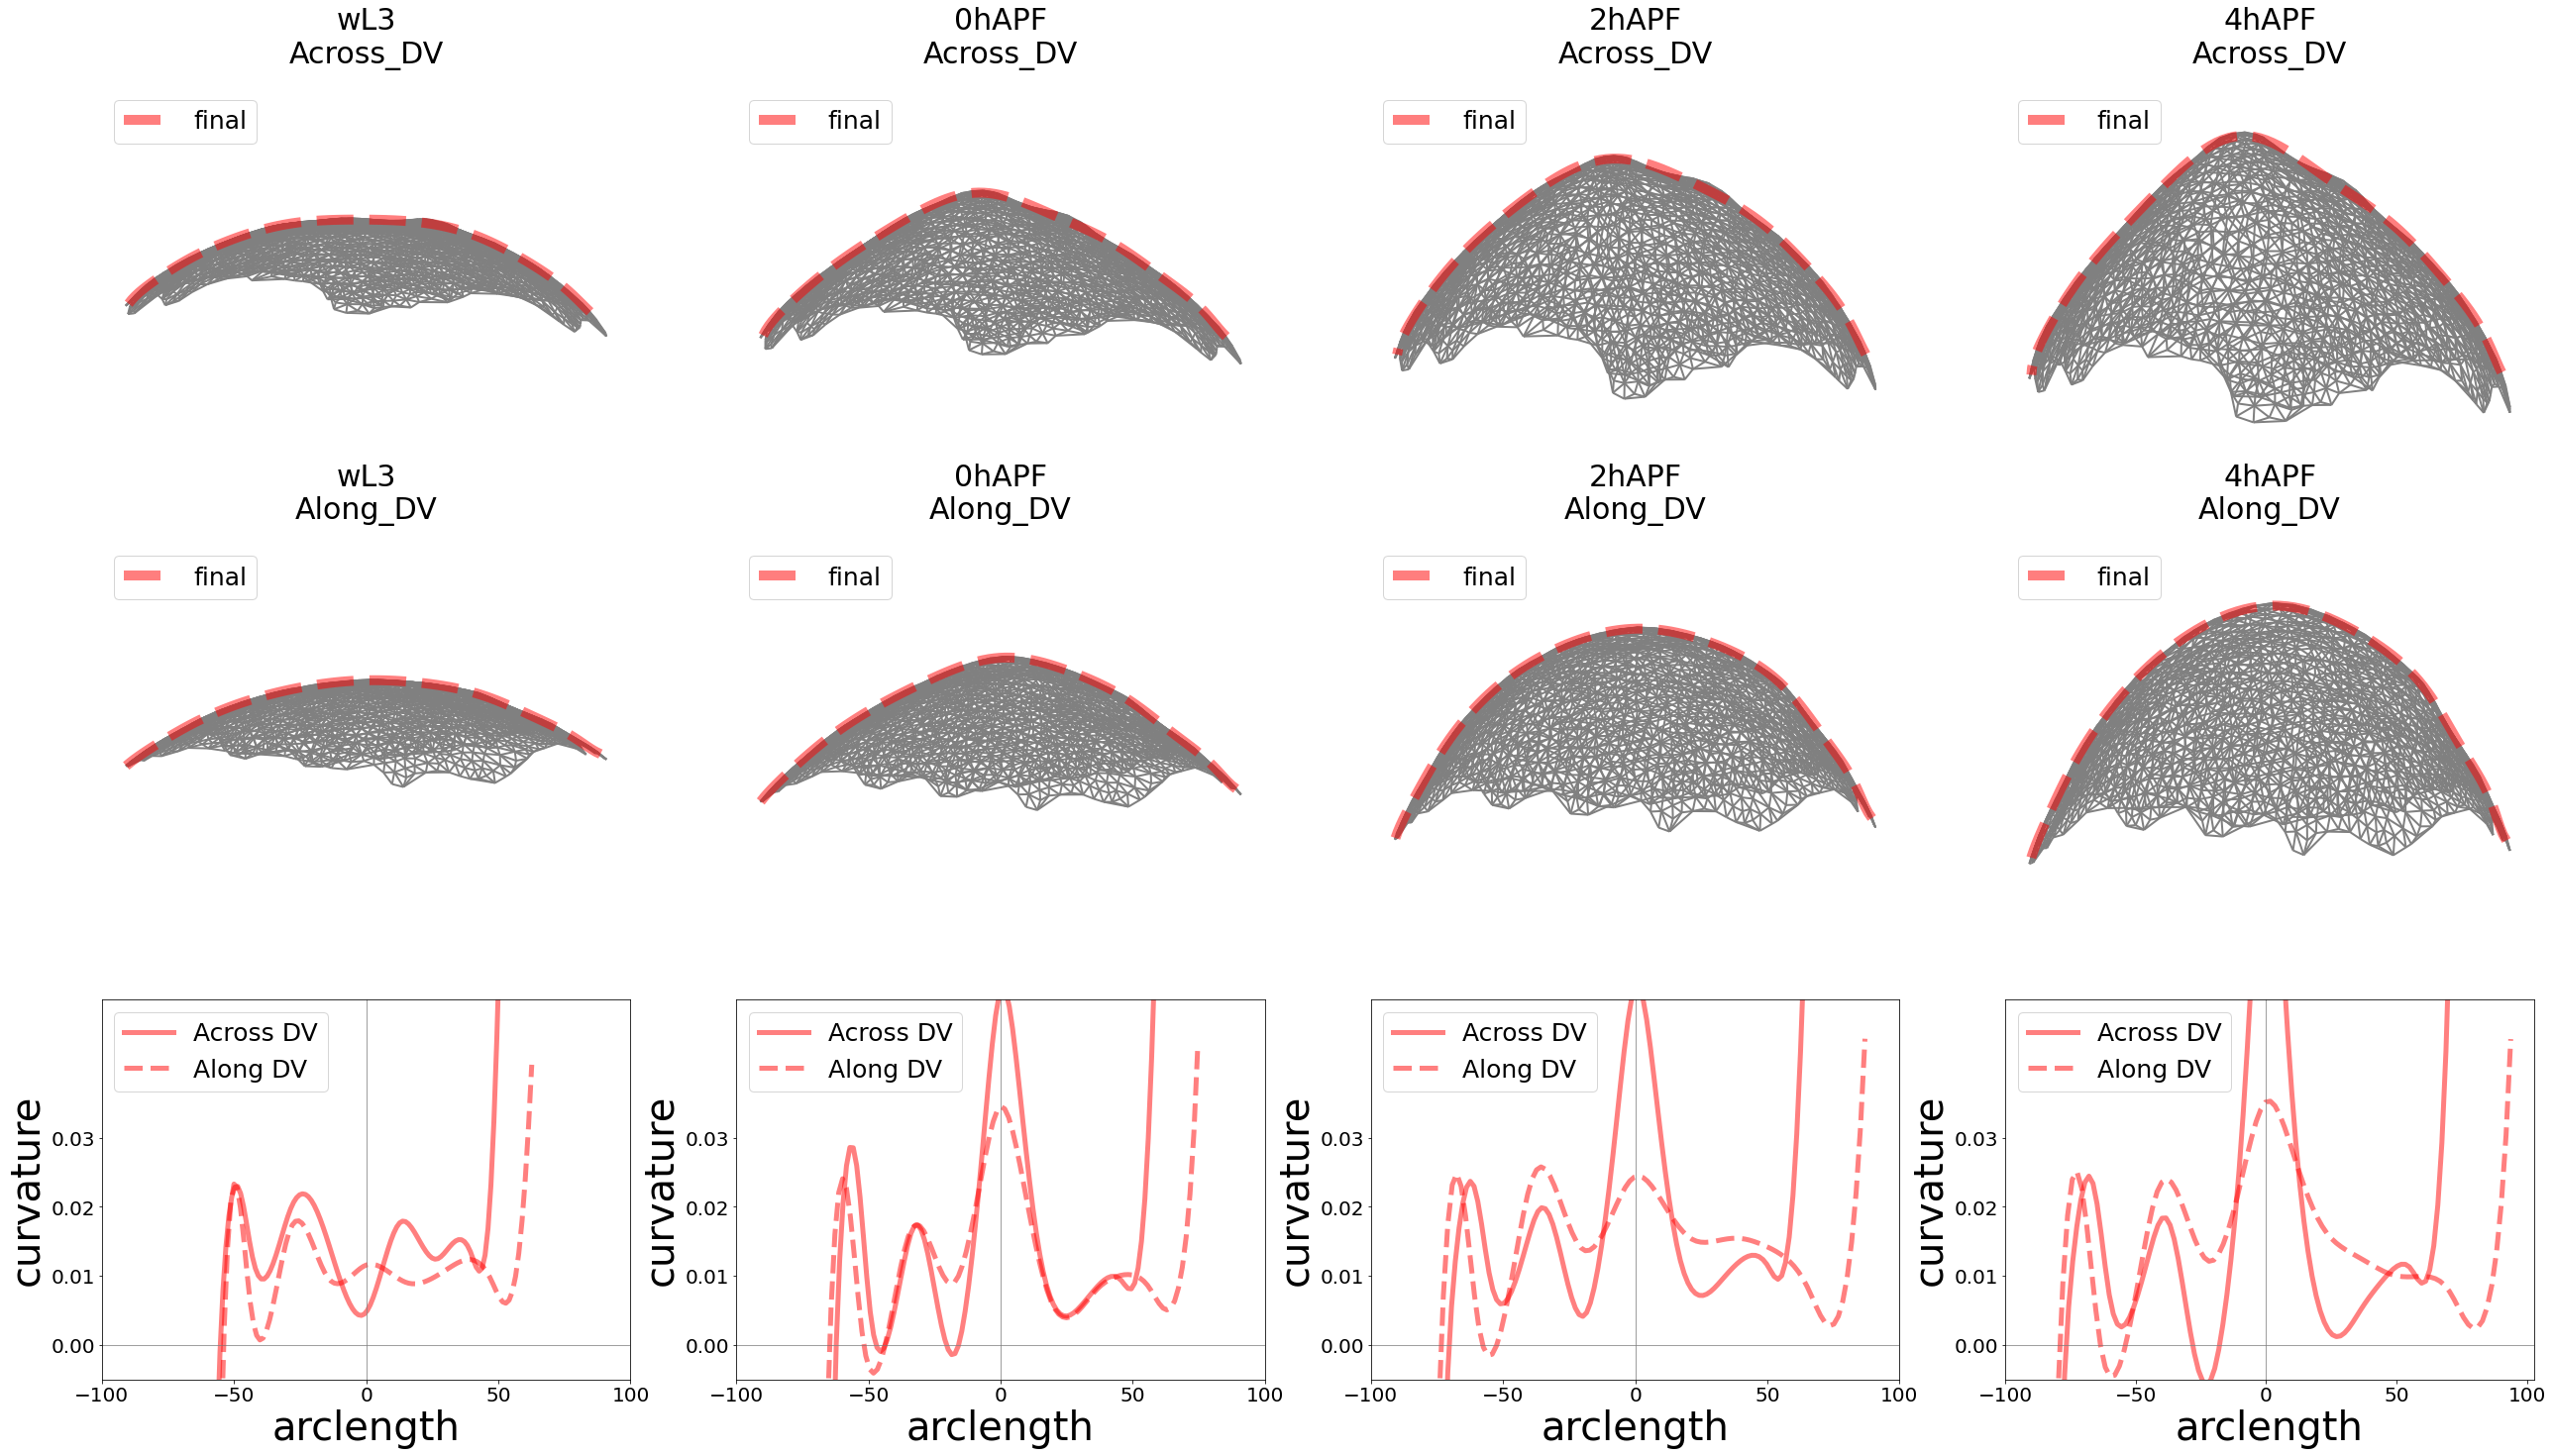

In [130]:
%matplotlib inline
init_mesh_path = dirname + "runfiles/init_mesh.pickle"

stages_df = pd.read_pickle(dirname+'runfiles/fit_lambdas_df.pkl')
stages = np.append(np.array(stages_df.iloc[0]["stage_init"]), np.array(stages_df.iloc[0:(len(np.unique(stages_df["stage_final"])))]["stage_final"]))
stage_names = np.array(stages_df.iloc[0:(len(np.unique(stages_df["stage_name"])))]["stage_name"])

scale = 77.66
crosssections = ['Across_DV', 'Along_DV']
ncols = len(stages) #number of stages, read stages_df.pkl and get unique of stage
projection_y = 'z'

#take one which has all info (except xyz) which stay same between stages and crosssections
balls_timepoint = pd.read_csv(dirname + "sim_output/init_balls.csv")
springs_timepoint = pd.read_csv(dirname + "sim_output/init_springs.csv")

for i in range(len(stages)):
    
    stage = stages[i]
    if i>0: 
        #for consecutive stages, update the xyz values
        timepoint_pos = pd.read_csv(dirname + "sim_output/"+stage_names[i-1]+".csv")
        balls_timepoint[['x', 'y', 'z']] =  timepoint_pos[['x', 'y', 'z']]
        springs_timepoint = update_springs(springs_timepoint, balls_timepoint[['x', 'y', 'z']])
        
    for crosssection in crosssections:
    
        #take the cross-section
        projection_x = 'x' if crosssection == 'Across_DV' else 'y'
        curve = get_2D_curve_from_simulation(balls_timepoint, springs_timepoint, projection_x = projection_x, projection_y = projection_y)

        #interpolate - take curvature - define a center
        curve = curve.rename(columns={projection_x:"x", projection_y:"y"})
        smooth_curve = compute_2D_curve_curvature(curve)

        #scale the curve
        for prop in ["x", "y", "arclength"]: smooth_curve[prop+"_scaled"] = scale*smooth_curve[prop]
        smooth_curve["curvature_scaled"] = smooth_curve["curvature"]/scale

        #translate the curve
        center_point = smooth_curve[smooth_curve["arclength_scaled"].abs() == smooth_curve["arclength_scaled"].abs().min()][["x_scaled","y_scaled"]].values[0]
        smooth_curve[["x_scaled","y_scaled"]] = smooth_curve[["x_scaled", "y_scaled"]] - center_point

        #save
        smooth_curve.to_csv(dirname + 'sim_output/' + stage + '_' + crosssection + '_curve.csv', index = False)

#plotting


fig, axs = plt.subplots(3, ncols, figsize=(11*ncols, 24))
titles = [str(x) for x in crosssections]

for i in range(len(crosssections)):
    
    crosssection = crosssections[i]
        
    for j in range(len(stages)):
        
        stage = stages[j]
        #read the xyz values for different stages
        if j == 0:
            balls_timepoint = pd.read_csv(dirname + "sim_output/init_balls.csv")
            springs_timepoint = pd.read_csv(dirname + "sim_output/init_springs.csv")
        else:
            timepoint_pos = pd.read_csv(dirname + "sim_output/"+stage_names[j-1]+".csv")
            balls_timepoint[['x', 'y', 'z']] =  timepoint_pos[['x', 'y', 'z']]
            springs_timepoint = update_springs(springs_timepoint, balls_timepoint[['x', 'y', 'z']])
        
        #plot mesh and curve
        ax = axs[i] if ncols == 1 else axs[i, j]
        
        #read the 2D crosssection curve
        projection_x = 'x' if crosssection == 'Across_DV' else 'y'
        smooth_curve = pd.read_csv(dirname + 'sim_output/' + stage + '_' + crosssection + '_curve.csv')
            
        ax.axis('off')
        plot_shell_on_given_ax(balls_timepoint, springs_timepoint,
                               x = projection_x, y = projection_y,
                               ax = ax, fig = fig,
                               #line_color_values = 'final_vs_initial',
                               #cbar_name=r'$\frac{l_{final}}{l_{initial}}$',
                               #cmap = "jet",
                               plot_only_top=True,
                               #line_color_values = np.array([1]*len(springs_timepoint)),
                               show_cbar = False,
                               line_color = "gray",
                               #color_min = 0.6,
                               #color_max = 1.4,
                               line_color_values = np.array([1]*len(springs_timepoint))
                              )
        
        ax.set_title(stage + '\n' + crosssections[i], fontsize = 30, pad = 25)
        
        label = "Across DV" if i == 0 else "Along DV"
        linestyle = "-" if i == 0 else "--"

        ax.plot(smooth_curve.x, smooth_curve.y, alpha = 0.5, linewidth = 10, color = 'red', linestyle = '--', label = 'final')

        ax.legend(loc = 'upper left', fontsize = 25)
        ax.tick_params(axis='both', which='major', labelsize=20)

        # plot the curvature 
        ax = axs[2] if ncols == 1 else axs[2,j]
            
        ax.plot(smooth_curve['arclength_scaled'],smooth_curve['curvature_scaled'], 
                color = 'red', #alpha = 0.5,
                  #label = 'individual discs'
                  #color = single_color, 
                  linewidth = 5, alpha = 0.5, #linestyle = single_linestyle,
                linestyle = linestyle,
                label = label,
                 )
        #ax.set_ylim(-0.5,4.5)
        #if i == 0:
        #    ylim_max = max(smooth_curve['curvature']) + 0.1*np.abs(max(smooth_curve['curvature']))
        #    ylim_min = min(smooth_curve['curvature']) - 0.1*np.abs(min(smooth_curve['curvature']))

        ax.set(ylim = (-0.005,0.05),)
        ax.set_ylabel('curvature', fontsize = 40)
        ax.set_xlabel('arclength', fontsize = 40)
        ax.legend(loc = 'upper left', fontsize = 25)
        ax.axhline(0, linestyle = '-', c = 'grey', linewidth = 0.5)
        ax.axvline(0, linestyle = '-', c = 'grey', linewidth = 0.5)
        #ax.set_xticks([-0.8, -0.4, 0, 0.4, 0.8])
        ax.set_xticks([-100, -50, 0, 50, 100])
        ax.set_yticks([ 0, 0.01, 0.02, 0.03])
        #ax.set_yticks([-2, 0, 2])
        ax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig(dirname + 'sim_output/crosssection_stages_plot.pdf', bbox_inches = 'tight')


# Archive

In [ ]:
from curvature_functions import *
from wd_functions import *

map_index_dest= sys.argv[1] #"map_index_0.csv"
task_id= int(sys.argv[2]) #0

#reading the map_index csv
print('reading the map_index csv')
map_index=pd.read_csv(map_index_dest)
input_var=list(map_index.columns) #variables for which values are being imported
for i in range(len(input_var)):
    if input_var[i] == 'folder_name':
        dirname = map_index.loc[task_id,str(input_var[i])]
    if input_var[i] == 'thickness':
        thickness = map_index.loc[task_id,str(input_var[i])]
        #init_mesh_path = 'gmsh_r_30_rotated_spherical_cap_theta_23.08_thickness_' + str(thickness) + '.pickle'
    #var_dict[input_var[i]]=map_index.loc[task_id,str(input_var[i])]
init_mesh_path = dirname + "runfiles/init_mesh.pickle"

#timepoints = [0,10,20,30] #during simulation, write in csv file
#stages_df = pd.read_csv(dirname+'runfiles/fit_lambdas_df.csv')
stages_df = pd.read_pickle(dirname+'runfiles/fit_lambdas_df.pkl')
stages = np.append(np.array(stages_df.iloc[0]["stage_init"]), np.array(stages_df.iloc[0:(len(np.unique(stages_df["stage_final"])))]["stage_final"]))
stage_names = np.array(stages_df.iloc[0:(len(np.unique(stages_df["stage_name"])))]["stage_name"])

scale = 77.66
crosssections = ['Across_DV', 'Along_DV']
#ncols = len(crosssections)
ncols = len(stages) #number of stages, read stages_df.pkl and get unique of stage

fig, axs = plt.subplots(3, ncols, figsize=(11*ncols, 24))
titles = [str(x) for x in crosssections]
projection_y = 'z'



for i in range(len(crosssections)):
    
    crosssection = crosssections[i]
    
    if crosssection == 'Along_DV':
        projection_x = 'y' #for along DV cross-section
    elif crosssection == 'Across_DV':
        projection_x = 'x' #for across DV cross-section

    #get initial balls and springs and curve
    #init_path = 'simulation_data/gmsh_r_20_rotated_spherical_cap_theta_45_thickness_0.1.pickle'
    #[balls_initial, springs_initial] = pickle.load( open(init_mesh_path, 'rb') )
    balls_initial = pd.read_csv(dirname + "sim_output/init_balls.csv")
    springs_initial = pd.read_csv(dirname + "sim_output/init_springs.csv")
    balls_initial_unscaled = balls_initial.copy(deep = True)
    springs_initial_unscaled = springs_initial.copy(deep = True)    
    #[balls_df, springs_df] = pickle.load( open(init_mesh_path, 'rb') )
    springs_initial['l1_initial'] = springs_initial['l1']
    init_curve = get_2D_curve_from_simulation(springs_initial, #indices = xz_plane_springs_id, 
                                        projection_x = projection_x, projection_y = projection_y,
                                              balls_initial = balls_initial, springs_initial = springs_initial
                                        )
    init_smooth_curve = compute_2D_curve_curvature(init_curve[[projection_x, projection_y]])
    
    #scale balls
    balls_initial[['x', 'y', 'z']] = scale*balls_initial[['x', 'y', 'z']]
    z_offset = max(balls_initial['z'])
    balls_initial['z'] = balls_initial['z'] - z_offset

    #springs_timepoint
    springs_initial[['x1','y1','z1','x2','y2','z2']] = scale*springs_initial[['x1','y1','z1','x2','y2','z2']]
    springs_initial['z1'] =springs_initial['z1'] - z_offset
    springs_initial['z2'] =springs_initial['z2'] - z_offset
    
    #scale init_smooth_curve
    init_smooth_curve[['x_scaled','y_scaled','arclength_scaled']] = scale*init_smooth_curve[['x','y','arclength']]
    init_smooth_curve['y_scaled'] = init_smooth_curve['y_scaled'] - max(init_smooth_curve['y_scaled']) 
    init_smooth_curve['curvature_scaled'] = init_smooth_curve['curvature']/scale #here we divide by scale
    
    init_smooth_curve.to_csv(dirname + 'sim_output/' + crosssection + '_init_curve.csv', index = False)
    
    for j in range(len(stages)):
        
        #timepoint = timepoints[j]
        stage = stages[j]
        stage_name = None if j == 0 else stage_names[j-1]
        
        if j == 0:
            balls_timepoint = balls_initial.copy(deep = True)
            springs_timepoint = springs_initial.copy(deep = True)
            curve = init_curve.copy(deep = True)
            smooth_curve = init_smooth_curve.copy(deep = True)
        else:
        
            #get balls_timepoint
            #get springs_timepoint
            #timepoint_pos = pd.read_csv(dirname + "sim_output/growth_" + str(timepoint) + "/final_0_0.csv")
            #balls_timepoint[['x', 'y', 'z']] =  timepoint_pos[['x[0]', 'x[1]', 'x[2]']]
            try:
                timepoint_pos = pd.read_csv(dirname + "sim_output/"+stage_name+".csv")
            except:
                continue
            balls_timepoint[['x', 'y', 'z']] =  timepoint_pos[['x', 'y', 'z']]
            springs_timepoint = update_springs(springs_timepoint, balls_timepoint[['x', 'y', 'z']])

            # get smoothened final curve
            curve = get_2D_curve_from_simulation(springs_timepoint, #indices = xz_plane_springs_id, 
                                                 projection_x = projection_x, projection_y = projection_y,
                                                 balls_initial = balls_initial_unscaled, springs_initial = springs_initial_unscaled,
                                                )
            try:
                smooth_curve = compute_2D_curve_curvature(curve[[projection_x, projection_y]])
            except:
                continue

            #scale things
            balls_timepoint[['x_scaled', 'y_scaled', 'z_scaled']] = scale*balls_timepoint[['x', 'y', 'z']]
            z_offset = max(balls_timepoint['z_scaled'])
            balls_timepoint['z_scaled'] = balls_timepoint['z_scaled'] - z_offset

            #springs_timepoint
            springs_timepoint[['x1_scaled','y1_scaled','z1_scaled','x2_scaled','y2_scaled','z2_scaled']] = scale*springs_timepoint[['x1','y1','z1','x2','y2','z2']]
            springs_timepoint['z1_scaled'] =springs_timepoint['z1_scaled'] - z_offset
            springs_timepoint['z2_scaled'] =springs_timepoint['z2_scaled'] - z_offset

            #smooth_curve
            smooth_curve[['x_scaled','y_scaled','arclength_scaled']] = scale*smooth_curve[['x','y','arclength']]
            smooth_curve['y_scaled'] = smooth_curve['y_scaled'] - max(smooth_curve['y_scaled'])
            smooth_curve['curvature_scaled'] = smooth_curve['curvature']/scale #here we divide by scale

        smooth_curve.to_csv(dirname + 'sim_output/' + stage + '_' + crosssection + '_curve.csv', index = False)
        #init_smooth_curve.to_csv(dirname + 'sim_output/' + crosssection + '_init_curve.csv', index = False)

        #plot mesh and curve
        if ncols == 1:
            ax = axs[i]
        else:
            ax = axs[i, j]
            
            
            
            
        ax.axis('off')
        plot_shell_on_given_ax(balls_timepoint, springs_timepoint,
                               x = projection_x, y = projection_y,
                               ax = ax, fig = fig,
                               #line_color_values = 'final_vs_initial',
                               #cbar_name=r'$\frac{l_{final}}{l_{initial}}$',
                               #cmap = "jet",
                               plot_only_top=True,
                               #line_color_values = np.array([1]*len(springs_timepoint)),
                               show_cbar = False,
                               line_color = "gray",
                               #color_min = 0.6,
                               #color_max = 1.4,
                               line_color_values = np.array([1]*len(springs_timepoint))
                              )
        
        ax.set_title(stage + '\n' + crosssections[i], fontsize = 30, pad = 25)
        
        if i == 0:
            linestyle = "-"
            label = "Across DV"
        else:
            linestyle = "--"
            label = "Along DV"

        ax.plot(smooth_curve.x, smooth_curve.y, alpha = 0.5, linewidth = 10, color = 'red', linestyle = '--', label = 'final')
        ax.plot(init_smooth_curve.x, init_smooth_curve.y, alpha = 0.5, linewidth = 10, color = 'blue', linestyle = '--', label = 'initial')

        ax.legend(loc = 'upper left', fontsize = 25)
        ax.tick_params(axis='both', which='major', labelsize=20)


        # plot the curvature 
        if ncols == 1:
            ax = axs[2]
        else:
            ax = axs[2,j]
            
        ax.plot(smooth_curve['arclength_scaled'],smooth_curve['curvature_scaled'], 
                color = 'red', #alpha = 0.5,
                  #label = 'individual discs'
                  #color = single_color, 
                  linewidth = 5, alpha = 0.5, #linestyle = single_linestyle,
                linestyle = linestyle,
                label = label,
                 )
        #ax.set_ylim(-0.5,4.5)
        #if i == 0:
        #    ylim_max = max(smooth_curve['curvature']) + 0.1*np.abs(max(smooth_curve['curvature']))
        #    ylim_min = min(smooth_curve['curvature']) - 0.1*np.abs(min(smooth_curve['curvature']))

        ax.set(ylim = (-0.005,0.05),)
        ax.set_ylabel('curvature', fontsize = 40)
        ax.set_xlabel('arclength', fontsize = 40)

        #plot initial curvature
        if i == 0:
            ax.plot(init_smooth_curve['arclength_scaled'],init_smooth_curve['curvature_scaled'], 
                    color = 'blue', #alpha = 0.5,
                      #label = 'individual discs'
                      #color = single_color, 
                      linewidth = 5, alpha = 0.5, #linestyle = single_linestyle,
                    label = 'initial',
                     )
        ax.legend(loc = 'upper left', fontsize = 25)
        ax.axhline(0, linestyle = '-', c = 'grey', linewidth = 0.5)
        ax.axvline(0, linestyle = '-', c = 'grey', linewidth = 0.5)
        #ax.set_xticks([-0.8, -0.4, 0, 0.4, 0.8])
        ax.set_xticks([-100, -50, 0, 50, 100])
        ax.set_yticks([ 0, 0.01, 0.02, 0.03])
        #ax.set_yticks([-2, 0, 2])
        ax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig(dirname + 'sim_output/crosssection_stages_plot.pdf', bbox_inches = 'tight')







########

skipby = 5

############
# Adding properties to edges
############

springs_df = pd.read_csv(dirname + 'sim_output/init_springs.csv')
balls_df = pd.read_csv(dirname + 'sim_output/init_balls.csv')



files = glob.glob(dirname + "sim_output/growth_*/")
times_str = [re.search('growth_(.*)/',x).group(1) for x in files]
times = []
for i in range(len(times_str)):
    if len(times_str[i]) == 0:
        continue
    times.append(int(times_str[i]))
times = np.sort(times)



for t in times:

    if not(t%skipby == 0):
        if not(t == times[-1]):
            continue

    print('timepoint : ' + str(t))
    
    df_timepoint = pd.read_csv(dirname + 'sim_output/growth_' + str(t) + '/final_0_0.csv') 
    balls_df[['x', 'y', 'z']] = df_timepoint[['x[0]', 'x[1]', 'x[2]']]
    springs_df = update_springs(springs_df, balls_df[['x', 'y', 'z']])
    
    #calculating some properties that are not there already
    springs_df['l0_target/l1'] = springs_df['l0_target']/springs_df['l1']
    springs_df['l1/l0_target'] = springs_df['l1']/springs_df['l0_target']
    springs_df['l0_target_final/l1'] = springs_df['l0_target_final']/springs_df['l1']
    springs_df['l1/l0_target_final'] = springs_df['l1']/springs_df['l0_target_final']
    springs_df['l0/l1_initial'] = springs_df['l0']/springs_df['l1_initial']
    springs_df['l1/l1_initial'] = springs_df['l1']/springs_df['l1_initial']
    springs_df['l0/l1'] = springs_df['l0']/springs_df['l1']
    springs_df['l1/l0'] = springs_df['l0']/springs_df['l1']
    
    
    dfToVtk(balls_df,springs_df,filename=dirname + 'sim_output/bulk_'+ str(t) + '.vtk',
        add_polygons = True)

    #getting vtk with properties on thick mesh
    dfToVtk(balls_df, springs_df, add_lines_properties=True, return_text=False,
            filename = dirname + 'sim_output/thick_wireframe_'+ str(t) + '.vtk',
           )
    
    #getting vtk with properties on thick mesh
    #dfToVtk(balls_df, springs_df, only_top_surface=True, add_lines_properties=True, return_text=False,
    #        filename = dirname + 'sim_output/top_wireframe_'+ str(t) + '.vtk',
    #       )
    #dfToVtk(balls_df, springs_df, only_bottom_surface=True, add_lines_properties=True, return_text=False,
    #        filename = dirname + 'sim_output/bottom_wireframe_'+ str(t) + '.vtk',
    #       )






#############
# Adding curvature
#############

#not every file needs to be computed because it takes long



springs = pd.read_csv(dirname + 'sim_output/init_springs.csv')
balls = pd.read_csv(dirname + 'sim_output/init_balls.csv')

files = glob.glob(dirname + "sim_output/growth_*/")
times_str = [re.search('growth_(.*)/',x).group(1) for x in files]
times = []
for i in range(len(times_str)):
    if len(times_str[i]) == 0:
        continue
    times.append(int(times_str[i]))
times = np.sort(times)



#get the r theta and phi values
#def cart2sph(x, y, z):
#    hxy = np.hypot(x, y)
#    r = np.hypot(hxy, z)
#    el = np.arctan2(hxy, z)
#    az = np.arctan2(y, x)
#    return r, el, az

rs, thetas, phis = cart2sph(balls['x'].values, balls['y'].values, balls['z'].values)
balls['theta'] = thetas
balls['r'] = rs
balls['phi'] = phis

balls_init = balls.copy(deep = True)
springs_init = springs.copy(deep = True)

#########
# getting the top and bottom surfaces
########

print('getting top surface')
#get top surface
springs_top = springs[(springs['ball1'] >= len(balls)/2) & (springs['ball2'] >= len(balls)/2)]
balls_top = balls[balls['ID'] >= len(balls)/2]
top_id_array = balls_top['ID'].values
#reindex
[balls_top, springs_top] = reindex_balls_springs(balls_top, springs_top)
#get triangles
print('getting triangles')
triangles_top = get_oriented_triangles(balls_top, springs_top)
#get indices of vertices that are not on the boundary
#we need these vertices because the Gaussian curvature is not calculated on the boundary vertices
nonboundary_id_top = balls_top.loc[balls_top['theta'] < 0.9*max(balls_top['theta']),'ID']

#print('getting bottom surface')
#get bottom surface
#springs_bottom = springs[(springs['ball1'] < len(balls)/2) & (springs['ball2'] < len(balls)/2)]
#balls_bottom = balls[balls['ID'] < len(balls)/2]
#bottom_id_array = balls_bottom['ID'].values
#reindex
#[balls_bottom, springs_bottom] = reindex_balls_springs(balls_bottom, springs_bottom)
#get triangles
#print('getting triangles')
#triangles_bottom = get_oriented_triangles(balls_bottom, springs_bottom)
#get indices of vertices that are not on the boundary
#we need these vertices because the Gaussian curvature is not calculated on the boundary vertices
#nonboundary_id_bottom = balls_bottom.loc[balls_bottom['theta'] < 0.9*max(balls_bottom['theta']),'ID']

print('measuring curvature')

for t in times:

    if not(t%skipby == 0):
        if not(t == times[-1]):
            continue

    print('timepoint : ' + str(t))
    
    df_timepoint = pd.read_csv(dirname + 'sim_output/growth_' + str(t) + '/final_0_0.csv') 
    balls[['x', 'y', 'z']] = df_timepoint[['x[0]', 'x[1]', 'x[2]']]
    springs = update_springs(springs, balls[['x', 'y', 'z']])
    
    
    #balls_bottom[['x','y','z']] = balls.loc[bottom_id_array, ['x','y','z']].values
    balls_top[['x','y','z']] = balls.loc[top_id_array, ['x','y','z']].values

    #measure curvature
    #if not(os.path.exists(dirname + 'sim_output/bottom_surface_'+ str(t) + '.vtk')):
    #[gc_bottom, mc_bottom, triangles_db_bottom, vertices_db_bottom] = measure_integrated_curvature(balls_bottom, springs_bottom, triangles = triangles_bottom,
    #                                                                                               filename = dirname + 'sim_output/bottom_surface_'+ str(t) + '.vtk',
    #                                                                                               nonboundary_indices = nonboundary_id_bottom, write_vtk=True,
    #                                                                                               z_offset = -0.0001
    #                                                                                              )
    #if not(os.path.exists(dirname + 'sim_output/top_surface_'+ str(t) + '.vtk')):
    [gc_top, mc_top, triangles_db_top, vertices_db_top] = measure_integrated_curvature(balls_top, springs_top, triangles = triangles_top,
                                                                                       filename = dirname + 'sim_output/top_surface_'+ str(t) + '.vtk',
                                                                                       nonboundary_indices = nonboundary_id_top, write_vtk=True,
                                                                                       z_offset = 0.0001
                                                                                      )
    #mean_integrated_gc = 0.5*(gc_top + gc_bottom)
    #mean_integrated_mc = 0.5*(mc_top + mc_bottom)



######






###########################################
# Measuring curvature of 2D crosssections # 
###########################################

scale = 167.13
crosssections = ['Across_DV', 'Along_DV']
ncols = len(crosssections)
fig, axs = plt.subplots(2, ncols, figsize=(11*ncols, 16))
titles = [str(x) for x in crosssections]
projection_y = 'z'

for i in range(len(crosssections)):
    
    crosssection = crosssections[i]
    
    if crosssection == 'Along_DV':
        projection_x = 'y' #for along DV cross-section
    elif crosssection == 'Across_DV':
        projection_x = 'x' #for across DV cross-section

    #get initial balls and springs and curve
    #init_path = 'simulation_data/gmsh_r_20_rotated_spherical_cap_theta_45_thickness_0.1.pickle'
    [balls_df, springs_df] = pickle.load( open(init_mesh_path, 'rb') )
    springs_df['l1_initial'] = springs_df['l1']
    init_curve = get_2D_curve_from_simulation(springs_df, #indices = xz_plane_springs_id, 
                                        projection_x = projection_x, projection_y = projection_y,
                                              balls_initial = balls_df, springs_initial = springs_df
                                        )
    init_smooth_curve = compute_2D_curve_curvature(init_curve[[projection_x, projection_y]])
    
    #get final balls and springs
    #print(dirname)
    [balls_timepoint, springs_timepoint] = get_final_dataframe(path = dirname+'sim_output/', 
                                                               balls_initial=balls_df, 
                                                               springs_initial=springs_df
                                                              )
    

    # get smoothened final curve
    curve = get_2D_curve_from_simulation(springs_timepoint, #indices = xz_plane_springs_id, 
                                         projection_x = projection_x, projection_y = projection_y,
                                         balls_initial = balls_df, springs_initial = springs_df
                                        )
    smooth_curve = compute_2D_curve_curvature(curve[[projection_x, projection_y]])
    
    #scale things
    balls_timepoint[['x', 'y', 'z']] = scale*balls_timepoint[['x', 'y', 'z']]
    z_offset = max(balls_timepoint['z'])
    balls_timepoint['z'] = balls_timepoint['z'] - z_offset
    
    #springs_timepoint
    springs_timepoint[['x1','y1','z1','x2','y2','z2']] = scale*springs_timepoint[['x1','y1','z1','x2','y2','z2']]
    springs_timepoint['z1'] =springs_timepoint['z1'] - z_offset
    springs_timepoint['z2'] =springs_timepoint['z2'] - z_offset
    
    #smooth_curve
    smooth_curve[['x','y','arclength']] = scale*smooth_curve[['x','y','arclength']]
    smooth_curve['y'] = smooth_curve['y'] - max(smooth_curve['y'])
    smooth_curve['curvature'] = smooth_curve['curvature']/scale #here we divide by scale
    
    #init_smooth_curve
    init_smooth_curve[['x','y','arclength']] = scale*init_smooth_curve[['x','y','arclength']]
    init_smooth_curve['y'] = init_smooth_curve['y'] - max(init_smooth_curve['y']) 
    init_smooth_curve['curvature'] = init_smooth_curve['curvature']/scale #here we divide by scale
    
    smooth_curve.to_csv(dirname + 'sim_output/' + crosssection + '_curve.csv', index = False)
    init_smooth_curve.to_csv(dirname + 'sim_output/' + crosssection + '_init_curve.csv', index = False)
    
    #plot mesh and curve
    if ncols == 1:
        ax = axs[0]
    else:
        ax = axs[0,i]
    ax.axis('off')

    plot_shell_on_given_ax(balls_timepoint, springs_timepoint,
                           x = projection_x, y = projection_y,
                           ax = ax, fig = fig,
                           line_color_values = 'final_vs_initial',
                           cbar_name=r'$\frac{l_{final}}{l_{initial}}$'
                          )
    ax.set_title(crosssections[i], fontsize = 30, pad = 25)
    
    ax.plot(smooth_curve.x, smooth_curve.y, alpha = 0.5, linewidth = 10, color = 'red', linestyle = '--', label = 'final')
    ax.plot(init_smooth_curve.x, init_smooth_curve.y, alpha = 0.5, linewidth = 10, color = 'blue', linestyle = '--', label = 'initial')
    
    ax.legend(loc = 'upper left', fontsize = 25)
    ax.tick_params(axis='both', which='major', labelsize=20)

    
    # plot the curvature 
    if ncols == 1:
        ax = axs[1]
    else:
        ax = axs[1,i]
        
    ax.plot(smooth_curve['arclength'],smooth_curve['curvature'], 
            color = 'red', #alpha = 0.5,
              #label = 'individual discs'
              #color = single_color, 
              linewidth = 10, alpha = 0.5, #linestyle = single_linestyle,
            label = 'final',
             )
    #ax.set_ylim(-0.5,2)
    if i == 0:
        ylim_max = max(smooth_curve['curvature']) + 0.1*np.abs(max(smooth_curve['curvature']))
        ylim_min = min(smooth_curve['curvature']) - 0.1*np.abs(min(smooth_curve['curvature']))

    ax.set(ylim = (-0.005,0.05),)
    ax.set_ylabel('curvature', fontsize = 40)
    ax.set_xlabel('arclength', fontsize = 40)
    
    #plot initial curvature
    
    ax.plot(init_smooth_curve['arclength'],init_smooth_curve['curvature'], 
            color = 'blue', #alpha = 0.5,
              #label = 'individual discs'
              #color = single_color, 
              linewidth = 10, alpha = 0.5, #linestyle = single_linestyle,
            label = 'initial',
             )
    ax.legend(loc = 'upper left', fontsize = 25)
    ax.axhline(0, linestyle = '-', c = 'grey', linewidth = 0.5)
    ax.axvline(0, linestyle = '-', c = 'grey', linewidth = 0.5)
    #ax.set_xticks([-0.8, -0.4, 0, 0.4, 0.8])
    ax.set_xticks([-100, -50, 0, 50, 100])
    ax.set_yticks([ 0, 0.02, 0.04])
    #ax.set_yticks([-2, 0, 2])
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    
plt.savefig(dirname + 'sim_output/final_crosssection_plot.pdf', bbox_inches = 'tight')

